<a href="https://colab.research.google.com/github/mvince33/Coding-Dojo/blob/main/week08/6_20_Code_Challenge_boosting_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boosting Live Class Challenge Sample 


## Classification: Data at: [Churn Modeling](https://drive.google.com/file/d/1_6ct38p8qzXSNmgrX4UGcbzhjqA74Ht4/view?usp=sharing)

Task: predict which customers will churn (`Exited` column)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
def make_confmat(y_true, y_pred, labels=None, savepath=None, cmap='Greens',
                 normalize=None):
  """
  Takes a vector of true labels and a vector of predicted labels.
  
  Optional Arguments:
  labels: labels for X and Y ticks, default None
  savepath: a path to save the plot to, default None
  cmap: a color map, default 'Greens'
  normalize: whether to normalize the annotated values in the boxes
    Options: ['true', 'pred', 'all'].  Default None
  returns a confusion matrix figure.
  """
  conf_mat = confusion_matrix(y_true, y_pred, normalize=normalize)
  figure = sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, 
                       annot=True, cmap=cmap)
  if savepath:
    plt.savefig(savepath)
  return figure

## Load and examine data

In [3]:
path = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vS71sJ-vej4Tegrs6PefHyIvROPUMMvzlM2cBFtO2-VfBbu4UzCcjr7H7Mn7MxB7UFQT7BvTfZ19ByS/pub?output=csv'
churn_df = pd.read_csv(path)
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


The RowNumber, CustomerId, and Surname are irrelevant to churn and are highly specific to each customer.  We will drop them.

In [5]:
churn_df = churn_df.drop(columns=['RowNumber','CustomerId','Surname'])

In [6]:
churn_df.duplicated().sum()

0

Use a seaborn pairplot to examine the distributions of and correlations between columns (distributions are on the diagonal)

In [7]:
churn_df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Quite a lot of the samples have a balance of 0.  In fact, the entire first quartile has a balance of 0.

We can see above that most variable seem to pretty independent.  Age is left skewed a little, and Exited is imbalanced.  We were worried about how many customers had 0 balances, but oddly it doesn't seem to be extremely correlated with whether they churn.  Age does seem to have some correlation, however, with younger people more likely to churn.

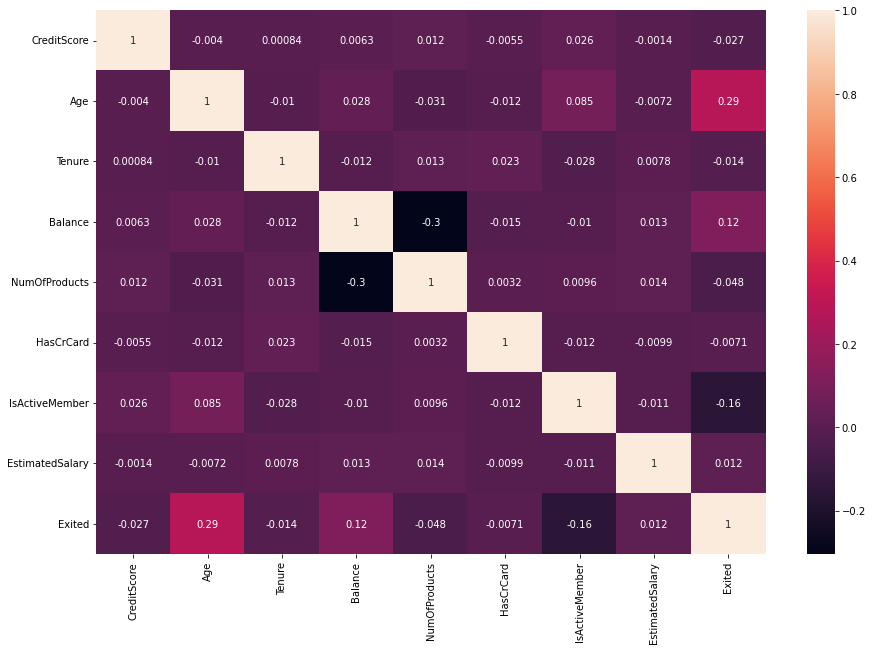

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(churn_df.corr(), annot=True, ax=ax)

This correlation heatmap confirms the correlation between age and churn.  Interestingly, people with a larger balance also seem to have fewer of the banks products.  Being an active member also seems to be negatively correlated with churn.

The correlations are not too bad, so we'll keep all of our columns for now.

In [9]:
churn_df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

# Class Balance

This dataset has about a 1:4 imbalance in favor of non-churning customers.


In [10]:
X = churn_df.drop(columns='Exited')
y = churn_df['Exited']

#Stratify to make sure we have the same class balance in train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Preprocessing Pipeline

A ColumnTransformer allows you to apply different preprocessing steps to different columns.  In this case we want to one-hot encode the categorical columns and scale the numeric columns.

A ColumnSelector returns certain columns based on their data type.  ColumnTransformer can also just take a list of column names instead if desired.

In [11]:
ohe = OneHotEncoder()
scaler = StandardScaler()

#column_selectors to tell the column transformers which columns to apply which preprocessing to
category_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number')

#column transformer
column_transformer = make_column_transformer((ohe, category_selector), (scaler, number_selector))


# Adaboost

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1991
           1       0.73      0.50      0.59       509

    accuracy                           0.86      2500
   macro avg       0.81      0.72      0.75      2500
weighted avg       0.85      0.86      0.85      2500



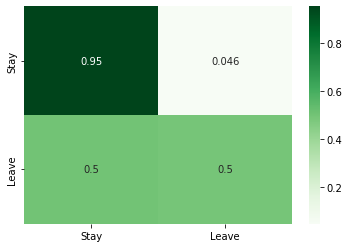

In [12]:
labels = ['Stay','Leave']
ada_pipe = make_pipeline(column_transformer, AdaBoostClassifier())
ada_pipe.fit(X_train, y_train)
y_hat = ada_pipe.predict(X_test)

print(classification_report(y_test, y_hat))
conf_mat = make_confmat(y_test, y_hat, labels=labels, normalize = 'true', 
                        savepath='xgboost_conf_mat.png')
conf_mat

# Light GBM

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1991
           1       0.75      0.50      0.60       509

    accuracy                           0.86      2500
   macro avg       0.81      0.73      0.76      2500
weighted avg       0.85      0.86      0.85      2500



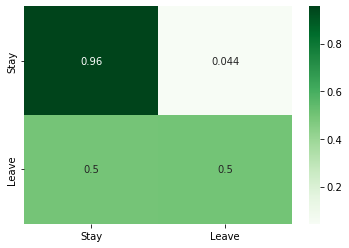

In [13]:
lgb_pipe = make_pipeline(column_transformer, LGBMClassifier())
lgb_pipe.fit(X_train, y_train)
y_hat = lgb_pipe.predict(X_test)

print(classification_report(y_test, y_hat))
conf_mat = make_confmat(y_test, y_hat, labels=labels, normalize = 'true', 
                        savepath='xgboost_conf_mat.png')
conf_mat

# XGBoost

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1991
           1       0.81      0.49      0.61       509

    accuracy                           0.87      2500
   macro avg       0.85      0.73      0.77      2500
weighted avg       0.87      0.87      0.86      2500



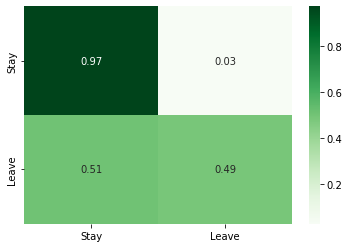

In [14]:
xgb_pipe = make_pipeline(column_transformer, XGBClassifier())
xgb_pipe.fit(X_train, y_train)
y_hat = xgb_pipe.predict(X_test)

print(classification_report(y_test, y_hat))
conf_mat = make_confmat(y_test, y_hat, labels=labels, normalize = 'true', 
                        savepath='xgboost_conf_mat.png')
conf_mat

# Evaluation:

1. Which metrics are most important for this business case?  

2. According to these metrics, what will this model be good at?  What will it be bad at?

# Next Steps:

What would you do next to make this model better?

1. 
2. 
3. 
